In [ ]:
# this is notebook about random forest model training and evaluation
# we will use the provided feature set and new feature set and deep feature respectively and combination of first two set to test the model

In [2]:
# random Forest model trainig and evaluation
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
import time
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [3]:
# set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(" Starting Random Forest Training and Evaluation")
print("=" * 60)

# record start time
total_start_time = time.time()

# 1:load and prepare the data
print(" Loading datasets...")
loading_start_time = time.time()
train_metadata = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/train_metadata.csv")
print(f" Loaded metadata: {train_metadata.shape}")

# load the provided feature sets
print("   Loading provided features...")
color_hist = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/Features/color_histogram.csv")
hog_pca = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/Features/hog_pca.csv")
additional_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/Features/additional_features.csv")

print("   Loading new feature sets...")
# load new feature sets
new_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/new_features.csv")
deep_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/deep_features.csv")

loading_time = time.time() - loading_start_time
print(f" All datasets loaded in {loading_time:.1f}s")

print(f"   Color histogram: {color_hist.shape}")
print(f"   HOG PCA: {hog_pca.shape}")
print(f"   Additional features: {additional_features.shape}")
print(f"   New features: {new_features.shape}")
print(f"   Deep features: {deep_features.shape}")


#2 create the feature combinations
print("\n Creating feature combinations...")
combination_start_time = time.time()

# merge provided features
print("   Combining provided features...")
provided_features = color_hist.merge(hog_pca, on='image_path')
provided_features = provided_features.merge(additional_features, on='image_path')
print(f"    Provided features combined: {provided_features.shape}")

# create 4 feature sets
feature_sets = {}

print("   Creating feature set combinations...")
# 1. provided features only
feature_sets['Provided Features'] = provided_features.copy()

# 2. new features only
feature_sets['New Features'] = new_features.copy()

# 3. deep features only
feature_sets['Deep Features'] = deep_features.copy()

# 4. combined (Provided + New)
print("   Merging provided and new features...")
combined_features = provided_features.merge(new_features, on='image_path')
feature_sets['Combined (Provided + New)'] = combined_features.copy()

# add labels to each feature set
print("   Adding labels to feature sets...")
for name, features_df in tqdm(feature_sets.items(), desc="   Processing feature sets"):
    # merge with metadata to get labels
    features_with_labels = features_df.merge(train_metadata[['image_path', 'ClassId']], on='image_path')
    feature_sets[name] = features_with_labels
    
    print(f"    {name}: {features_with_labels.shape} (features + label)")

combination_time = time.time() - combination_start_time
print(f" Feature combinations completed in {combination_time:.1f}s")

 Starting Random Forest Training and Evaluation
 Loading datasets...
 Loaded metadata: (5488, 5)
   Loading provided features...
   Loading new feature sets...
 All datasets loaded in 0.7s
   Color histogram: (5488, 97)
   HOG PCA: (5488, 21)
   Additional features: (5488, 5)
   New features: (5488, 57)
   Deep features: (5488, 2049)

 Creating feature combinations...
   Combining provided features...
    Provided features combined: (5488, 121)
   Creating feature set combinations...
   Merging provided and new features...
   Adding labels to feature sets...


   Processing feature sets: 100%|████████████████| 4/4 [00:00<00:00, 185.14it/s]

    Provided Features: (5488, 122) (features + label)
    New Features: (5488, 58) (features + label)
    Deep Features: (5488, 2050) (features + label)
    Combined (Provided + New): (5488, 178) (features + label)
 Feature combinations completed in 0.1s


In [4]:
#3:set up the cross-validation
print("\n Setting up cross-validation...")

# stratified K-Fold setup
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# results storage
cv_results = defaultdict(list)
feature_importance_results = {}


#4: hyperparameter tuning and do the evaluation

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

def tune_hyperparameters(X, y, cv_folds, quick_tune=True):
    """
    find best hyperparameters for Random Forest
    """
    print(" Tuning hyperparameters...")
    tune_start_time = time.time()
    
    # define parameter grid
    if quick_tune:
        # quick tuning for time constraints
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        total_combinations = len(param_grid['n_estimators']) * len(param_grid['max_depth']) * \
                           len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])
        
        print(f"   Testing {total_combinations} parameter combinations...")
        
        search = GridSearchCV(
            RandomForestClassifier(class_weight='balanced', random_state=RANDOM_SEED, n_jobs=-1),
            param_grid, cv=cv_folds, scoring='accuracy', n_jobs=-1, verbose=0
        )
    else:
        # more comprehensive tuning if needed (but not consider this due to time and computational constraints)
        # if in the future i have time and chance, i will try this.
        param_dist = {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
        print(f"   Testing 20 random parameter combinations...")
        
        search = RandomizedSearchCV(
            RandomForestClassifier(class_weight='balanced', random_state=RANDOM_SEED, n_jobs=-1),
            param_dist, n_iter=20, cv=cv_folds, scoring='accuracy', 
            random_state=RANDOM_SEED, n_jobs=-1, verbose=0
        )
    
    # standardize features for hyperparameter tuning
    print("   Standardizing features for tuning...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # perform search with progress
    print("   Running hyperparameter search...")
    search.fit(X_scaled, y)
    
    tune_time = time.time() - tune_start_time
    print(f"   Hyperparameter tuning completed in {tune_time:.1f}s")
    print(f"     Best parameters: {search.best_params_}")
    print(f"     Best CV score: {search.best_score_:.4f}")
    
    return search.best_params_, search.best_score_

def evaluate_feature_set(feature_set_name, features_df):
    """
    evaluate a feature set using stratified cross-validation with hyperparameter tuning
    """
    print(f"\n Training Random Forest on {feature_set_name}")
    print("-" * 50)
    
    eval_start_time = time.time()
    
    # prepare data
    X = features_df.drop(['image_path', 'ClassId'], axis=1)
    y = features_df['ClassId'].values
    
    print(f"Feature matrix: {X.shape}")
    print(f"Number of classes: {len(np.unique(y))}")
    
    # tune hyperparameters (using inner CV)
    best_params, best_cv_score = tune_hyperparameters(X, y, 3, quick_tune=True)
    
    # store results for this feature set
    fold_accuracies = []
    fold_reports = []
    all_feature_importances = []
    all_y_true = []
    all_y_pred = []
    all_val_indices = []
    
    # perform stratified cross-validation with best parameters
    print(f"\n    Running {N_FOLDS}-fold cross-validation...")
    
    cv_folds = list(skf.split(X, y))
    for fold, (train_idx, val_idx) in enumerate(tqdm(cv_folds, desc="   CV Folds", leave=False)):
        fold_start_time = time.time()
        
        # split data according to CV folds (IMPORTANT: no data leakage)
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y[train_idx]
        y_val_fold = y[val_idx]
        
        # standardize features (fit on train, transform both)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # train Random Forest with best parameters
        rf = RandomForestClassifier(
            class_weight='balanced',
            random_state=RANDOM_SEED,
            n_jobs=-1,
            **best_params  # Use tuned hyperparameters
        )
        
        rf.fit(X_train_scaled, y_train_fold)
        
        # predict on validation fold
        y_pred = rf.predict(X_val_scaled)
        
        # calculate accuracy
        fold_accuracy = accuracy_score(y_val_fold, y_pred)
        fold_accuracies.append(fold_accuracy)
        
        # store classification report
        report = classification_report(y_val_fold, y_pred, output_dict=True, zero_division=0)
        fold_reports.append(report)
        
        # store feature importances
        all_feature_importances.append(rf.feature_importances_)
        
        # store predictions for detailed analysis
        all_y_true.extend(y_val_fold)
        all_y_pred.extend(y_pred)
        all_val_indices.extend(val_idx)
        
        fold_time = time.time() - fold_start_time
        tqdm.write(f"      Fold {fold + 1}/{N_FOLDS}: Accuracy={fold_accuracy:.4f}, Time={fold_time:.1f}s")
    
    # calculate average results
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    
    # average feature importances
    avg_feature_importance = np.mean(all_feature_importances, axis=0)
    
    # store results
    cv_results[feature_set_name] = {
        'fold_accuracies': fold_accuracies,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'fold_reports': fold_reports,
        'best_params': best_params,
        'best_cv_score': best_cv_score,
        'all_y_true': all_y_true,
        'all_y_pred': all_y_pred,
        'val_indices': all_val_indices
    }
    
    feature_importance_results[feature_set_name] = {
        'importances': avg_feature_importance,
        'feature_names': X.columns.tolist()
    }
    
    eval_time = time.time() - eval_start_time
    print(f"   {feature_set_name} completed in {eval_time:.1f}s")
    print(f"     Average Accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")
    
    return mean_accuracy, std_accuracy


 Setting up cross-validation...


In [5]:
#5: train all feature sets
print("\n Training models on all feature sets...")
print("=" * 60)

training_start_time = time.time()

# train and evaluate each feature set with progress tracking
feature_set_names = list(feature_sets.keys())
print(f"Training {len(feature_set_names)} different feature sets...")

overall_progress = tqdm(feature_set_names, desc=" Overall Progress", position=0)

for i, feature_set_name in enumerate(overall_progress):
    features_df = feature_sets[feature_set_name]
    
    # update progress bar description
    overall_progress.set_description(f" Training {i+1}/{len(feature_set_names)}: {feature_set_name}")
    
    # evaluate this feature set
    mean_acc, std_acc = evaluate_feature_set(feature_set_name, features_df)
    
    # update progress bar with current results
    overall_progress.set_postfix({
        'Accuracy': f'{mean_acc:.3f}±{std_acc:.3f}',
        'Best_so_far': f'{max([cv_results[name]["mean_accuracy"] for name in cv_results.keys()]):.3f}'
    })

overall_progress.close()

training_time = time.time() - training_start_time
print(f"\n All model training completed in {training_time:.1f}s ({training_time/60:.1f} minutes)")
print(f"   Average time per feature set: {training_time/len(feature_set_names):.1f}s")


 Training models on all feature sets...
Training 4 different feature sets...


 Training 1/4: Provided Features:   0%|                   | 0/4 [00:00<?, ?it/s]


 Training Random Forest on Provided Features
--------------------------------------------------
Feature matrix: (5488, 120)
Number of classes: 43
 Tuning hyperparameters...
   Testing 36 parameter combinations...
   Standardizing features for tuning...
   Running hyperparameter search...
   Hyperparameter tuning completed in 28.9s
     Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
     Best CV score: 0.7824

    Running 5-fold cross-validation...



                                                                                
   CV Folds:  20%|██████▍                         | 1/5 [00:00<00:02,  1.37it/s]

      Fold 1/5: Accuracy=0.8060, Time=0.7s


                                                                                
   CV Folds:  40%|████████████▊                   | 2/5 [00:01<00:02,  1.38it/s]

      Fold 2/5: Accuracy=0.8024, Time=0.7s


                                                                                
   CV Folds:  60%|███████████████████▏            | 3/5 [00:02<00:01,  1.40it/s]

      Fold 3/5: Accuracy=0.8206, Time=0.7s


                                                                                
   CV Folds:  80%|█████████████████████████▌      | 4/5 [00:02<00:00,  1.40it/s]

      Fold 4/5: Accuracy=0.8058, Time=0.7s


                                                                                
   CV Folds: 100%|████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]
 Training 2/4: New Features:  25%|▎| 1/4 [00:32<01:37, 32.51s/it, Accuracy=0.808

      Fold 5/5: Accuracy=0.8067, Time=0.7s
   Provided Features completed in 32.5s
     Average Accuracy: 0.8083 (±0.0063)

 Training Random Forest on New Features
--------------------------------------------------
Feature matrix: (5488, 56)
Number of classes: 43
 Tuning hyperparameters...
   Testing 36 parameter combinations...
   Standardizing features for tuning...
   Running hyperparameter search...
   Hyperparameter tuning completed in 22.4s
     Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
     Best CV score: 0.5062

    Running 5-fold cross-validation...



                                                                                
 Training 2/4: New Features:  25%|▎| 1/4 [00:55<01:37, 32.51s/it, Accuracy=0.808
   CV Folds:  20%|██████▍                         | 1/5 [00:00<00:02,  1.86it/s]

      Fold 1/5: Accuracy=0.5082, Time=0.5s


                                                                                
 Training 2/4: New Features:  25%|▎| 1/4 [00:56<01:37, 32.51s/it, Accuracy=0.808
   CV Folds:  40%|████████████▊                   | 2/5 [00:01<00:01,  1.84it/s]

      Fold 2/5: Accuracy=0.5118, Time=0.5s


                                                                                
 Training 2/4: New Features:  25%|▎| 1/4 [00:56<01:37, 32.51s/it, Accuracy=0.808
   CV Folds:  60%|███████████████████▏            | 3/5 [00:01<00:01,  1.82it/s]

      Fold 3/5: Accuracy=0.5200, Time=0.6s


                                                                                
 Training 2/4: New Features:  25%|▎| 1/4 [00:57<01:37, 32.51s/it, Accuracy=0.808
   CV Folds:  80%|█████████████████████████▌      | 4/5 [00:02<00:00,  1.80it/s]

      Fold 4/5: Accuracy=0.4941, Time=0.6s


                                                                                
 Training 2/4: New Features:  25%|▎| 1/4 [00:57<01:37, 32.51s/it, Accuracy=0.808
   CV Folds: 100%|████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]
 Training 3/4: Deep Features:  50%|▌| 2/4 [00:57<00:56, 28.21s/it, Accuracy=0.50

      Fold 5/5: Accuracy=0.5059, Time=0.6s
   New Features completed in 25.2s
     Average Accuracy: 0.5080 (±0.0085)

 Training Random Forest on Deep Features
--------------------------------------------------
Feature matrix: (5488, 2048)
Number of classes: 43
 Tuning hyperparameters...
   Testing 36 parameter combinations...
   Standardizing features for tuning...
   Running hyperparameter search...
   Hyperparameter tuning completed in 124.2s
     Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
     Best CV score: 0.7961

    Running 5-fold cross-validation...



                                                                                
 Training 3/4: Deep Features:  50%|▌| 2/4 [03:04<00:56, 28.21s/it, Accuracy=0.50
   CV Folds:  20%|██████▍                         | 1/5 [00:02<00:10,  2.64s/it]

      Fold 1/5: Accuracy=0.8169, Time=2.6s


                                                                                
 Training 3/4: Deep Features:  50%|▌| 2/4 [03:07<00:56, 28.21s/it, Accuracy=0.50
   CV Folds:  40%|████████████▊                   | 2/5 [00:05<00:07,  2.63s/it]

      Fold 2/5: Accuracy=0.8087, Time=2.6s


                                                                                
 Training 3/4: Deep Features:  50%|▌| 2/4 [03:09<00:56, 28.21s/it, Accuracy=0.50
   CV Folds:  60%|███████████████████▏            | 3/5 [00:07<00:05,  2.63s/it]

      Fold 3/5: Accuracy=0.8033, Time=2.6s


                                                                                
 Training 3/4: Deep Features:  50%|▌| 2/4 [03:12<00:56, 28.21s/it, Accuracy=0.50
   CV Folds:  80%|█████████████████████████▌      | 4/5 [00:10<00:02,  2.63s/it]

      Fold 4/5: Accuracy=0.8195, Time=2.6s


                                                                                
 Training 3/4: Deep Features:  50%|▌| 2/4 [03:15<00:56, 28.21s/it, Accuracy=0.50
   CV Folds: 100%|████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [03:15<01:18, 78.06s/it, A

      Fold 5/5: Accuracy=0.8131, Time=2.7s
   Deep Features completed in 137.4s
     Average Accuracy: 0.8123 (±0.0058)

 Training Random Forest on Combined (Provided + New)
--------------------------------------------------
Feature matrix: (5488, 176)
Number of classes: 43
 Tuning hyperparameters...
   Testing 36 parameter combinations...
   Standardizing features for tuning...
   Running hyperparameter search...
   Hyperparameter tuning completed in 37.8s
     Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
     Best CV score: 0.7668

    Running 5-fold cross-validation...



                                                                                
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [03:53<01:18, 78.06s/it, A
   CV Folds:  20%|██████▍                         | 1/5 [00:00<00:03,  1.14it/s]

      Fold 1/5: Accuracy=0.7887, Time=0.9s


                                                                                
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [03:54<01:18, 78.06s/it, A
   CV Folds:  40%|████████████▊                   | 2/5 [00:01<00:02,  1.14it/s]

      Fold 2/5: Accuracy=0.7650, Time=0.9s


                                                                                
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [03:55<01:18, 78.06s/it, A
   CV Folds:  60%|███████████████████▏            | 3/5 [00:02<00:01,  1.13it/s]

      Fold 3/5: Accuracy=0.7951, Time=0.9s


                                                                                
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [03:56<01:18, 78.06s/it, A
   CV Folds:  80%|█████████████████████████▌      | 4/5 [00:03<00:00,  1.11it/s]

      Fold 4/5: Accuracy=0.7730, Time=0.9s


                                                                                
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [03:57<01:18, 78.06s/it, A
   CV Folds: 100%|████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]
 Training 4/4: Combined (Provided + New): 100%|█| 4/4 [03:57<00:00, 59.34s/it, A

      Fold 5/5: Accuracy=0.7830, Time=0.9s
   Combined (Provided + New) completed in 42.3s
     Average Accuracy: 0.7810 (±0.0108)

 All model training completed in 237.4s (4.0 minutes)
   Average time per feature set: 59.3s



 Results Summary

 Cross-Validation Results:
              Feature Set  Mean Accuracy  Std Accuracy  Min Accuracy  Max Accuracy
            Deep Features         0.8123        0.0058        0.8033        0.8195
        Provided Features         0.8083        0.0063        0.8024        0.8206
Combined (Provided + New)         0.7810        0.0108        0.7650        0.7951
             New Features         0.5080        0.0085        0.4941        0.5200

 Creating visualizations...


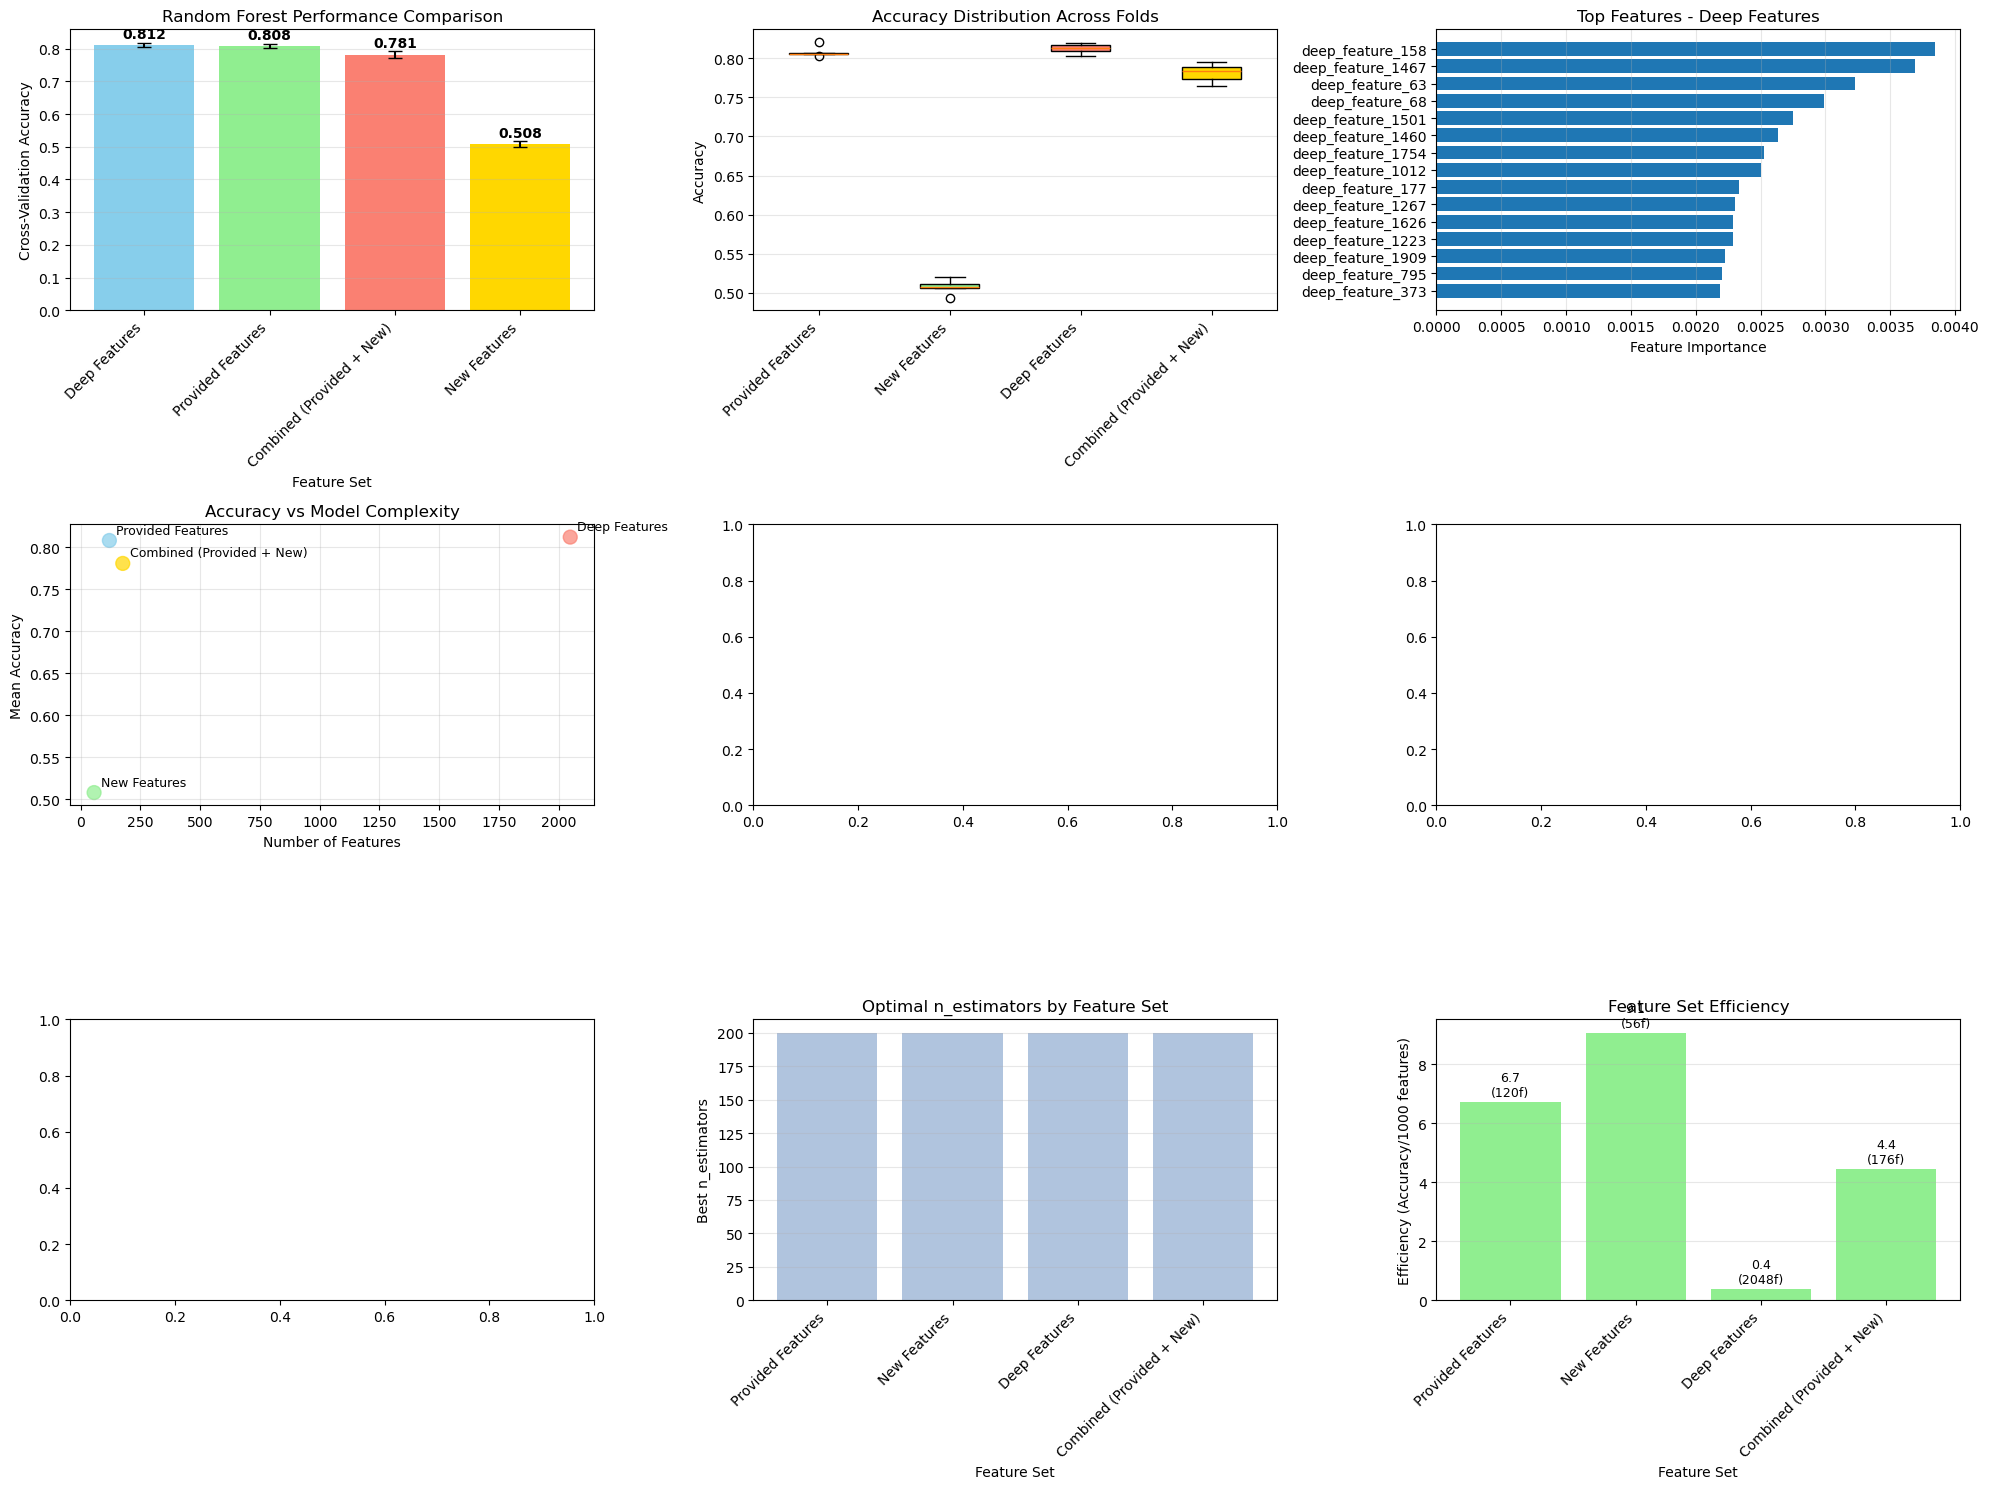


 Detailed Analysis:
----------------------------------------
 Best performing feature set: Deep Features
   Mean accuracy: 0.8123 (±0.0058)

 Best Hyperparameters:
   Provided Features: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
   New Features: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
   Deep Features: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
   Combined (Provided + New): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

 Performance ranking:
   3. Deep Features: 0.8123
   1. Provided Features: 0.8083
   4. Combined (Provided + New): 0.7810
   2. New Features: 0.5080

DETAILED ANALYSIS FOR BEST MODEL: Deep Features

 Detailed Analysis for Deep Features
--------------------------------------------------

 Per-Category Performance:
              Precision  Recall  F1-Score  Support
Category                     

In [6]:
# do the results comparison and visualisation for use to analysis
print("\n Results Summary")
print("=" * 60)

# create results summary
results_summary = []
for name, results in cv_results.items():
    results_summary.append({
        'Feature Set': name,
        'Mean Accuracy': results['mean_accuracy'],
        'Std Accuracy': results['std_accuracy'],
        'Min Accuracy': min(results['fold_accuracies']),
        'Max Accuracy': max(results['fold_accuracies'])
    })

# convert to DataFrame for easy viewing
results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Mean Accuracy', ascending=False)

print("\n Cross-Validation Results:")
print(results_df.to_string(index=False, float_format='%.4f'))

print("\n Creating visualizations...")

# create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# subplot 1: Mean accuracy with error bars
plt.subplot(3, 3, 1)
feature_names = results_df['Feature Set']
means = results_df['Mean Accuracy']
stds = results_df['Std Accuracy']

bars = plt.bar(range(len(feature_names)), means, yerr=stds, capsize=5, 
               color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.xlabel('Feature Set')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Random Forest Performance Comparison')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.005, f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

# subplot 2: Box plot of fold accuracies
plt.subplot(3, 3, 2)
unique_names = list(cv_results.keys())
box_data = [cv_results[name]['fold_accuracies'] for name in unique_names]

bp = plt.boxplot(box_data, labels=unique_names, patch_artist=True)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Accuracy')
plt.title('Accuracy Distribution Across Folds')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# subplot 3: Feature importance (for our best performing model)
plt.subplot(3, 3, 3)
best_model_name = results_df.iloc[0]['Feature Set']
best_importances = feature_importance_results[best_model_name]['importances']
best_feature_names = feature_importance_results[best_model_name]['feature_names']

# show top 15 most important features
top_indices = np.argsort(best_importances)[-15:]
top_importances = best_importances[top_indices]
top_names = [best_feature_names[i] for i in top_indices]

plt.barh(range(len(top_importances)), top_importances)
plt.yticks(range(len(top_importances)), top_names)
plt.xlabel('Feature Importance')
plt.title(f'Top Features - {best_model_name}')
plt.grid(axis='x', alpha=0.3)

# subplot 4: Model complexity comparison
plt.subplot(3, 3, 4)
n_features = [len(feature_importance_results[name]['feature_names']) for name in unique_names]
accuracies = [cv_results[name]['mean_accuracy'] for name in unique_names]

plt.scatter(n_features, accuracies, s=100, c=colors, alpha=0.7)
for i, name in enumerate(unique_names):
    plt.annotate(name, (n_features[i], accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Number of Features')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy vs Model Complexity')
plt.grid(alpha=0.3)

# subplot 5: Per-category performance (best model)
plt.subplot(3, 3, 5)
if 'category_perf' in locals():
    categories = category_perf.index
    f1_scores = category_perf['F1-Score']
    
    bars = plt.bar(range(len(categories)), f1_scores, color='lightcoral')
    plt.xlabel('Category')
    plt.ylabel('Mean F1-Score')
    plt.title(f'Per-Category Performance - {best_model_name}')
    plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, score in enumerate(f1_scores):
        plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# subplot 6: Class performance vs class frequency
plt.subplot(3, 3, 6)
if 'class_perf_df' in locals():
    plt.scatter(class_perf_df['Support'], class_perf_df['F1-Score'], alpha=0.6, color='mediumpurple')
    plt.xlabel('Class Frequency (Support)')
    plt.ylabel('F1-Score')
    plt.title('Class Performance vs Frequency')
    plt.grid(alpha=0.3)
    
    # Add trend line
    z = np.polyfit(class_perf_df['Support'], class_perf_df['F1-Score'], 1)
    p = np.poly1d(z)
    plt.plot(class_perf_df['Support'], p(class_perf_df['Support']), "r--", alpha=0.8)

# subplot 7: Confusion Matrix (for best model, top confusions only)
plt.subplot(3, 3, 7)
if 'cm' in locals() and 'confusion_df' in locals() and not confusion_df.empty:
    # Create a simplified confusion matrix showing only top confusions
    top_confusions = confusion_df.head(20)  # Top 20 confusions
    
    # Create matrix for visualization
    classes_involved = list(set(top_confusions['True_Class'].tolist() + top_confusions['Pred_Class'].tolist()))
    classes_involved.sort()
    
    if len(classes_involved) <= 15:  # Only if manageable size
        conf_matrix = np.zeros((len(classes_involved), len(classes_involved)))
        class_to_idx = {cls: i for i, cls in enumerate(classes_involved)}
        
        for _, row in top_confusions.iterrows():
            true_idx = class_to_idx[row['True_Class']]
            pred_idx = class_to_idx[row['Pred_Class']]
            conf_matrix[true_idx, pred_idx] = row['Count']
        
        sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Reds',
                   xticklabels=classes_involved, yticklabels=classes_involved)
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.title('Main Confusion Patterns')
    else:
        # Just show text summary if too many classes
        plt.text(0.1, 0.7, 'Top Confusions:', fontsize=12, fontweight='bold')
        for i, (_, row) in enumerate(confusion_df.head(5).iterrows()):
            plt.text(0.1, 0.6-i*0.1, f"{row['True_Class']}→{row['Pred_Class']}: {row['Count']}", fontsize=10)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.axis('off')
        plt.title('Most Confused Class Pairs')

# subplot 8: Hyperparameter comparison
plt.subplot(3, 3, 8)
if any('best_params' in cv_results[name] for name in unique_names):
    # Extract n_estimators for comparison
    n_estimators_values = []
    model_names = []
    for name in unique_names:
        if 'best_params' in cv_results[name]:
            n_estimators_values.append(cv_results[name]['best_params'].get('n_estimators', 100))
            model_names.append(name)
    
    if n_estimators_values:
        plt.bar(range(len(model_names)), n_estimators_values, color='lightsteelblue')
        plt.xlabel('Feature Set')
        plt.ylabel('Best n_estimators')
        plt.title('Optimal n_estimators by Feature Set')
        plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)

# subplot 9: Feature set efficiency
plt.subplot(3, 3, 9)
efficiency_scores = []
feature_counts = []
for name in unique_names:
    n_feat = len(feature_importance_results[name]['feature_names'])
    acc = cv_results[name]['mean_accuracy']
    efficiency = acc / n_feat * 1000  # Accuracy per 1000 features
    efficiency_scores.append(efficiency)
    feature_counts.append(n_feat)

bars = plt.bar(range(len(unique_names)), efficiency_scores, color='lightgreen')
plt.xlabel('Feature Set')
plt.ylabel('Efficiency (Accuracy/1000 features)')
plt.title('Feature Set Efficiency')
plt.xticks(range(len(unique_names)), unique_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# add value labels
for i, (eff, n_feat) in enumerate(zip(efficiency_scores, feature_counts)):
    plt.text(i, eff + 0.1, f'{eff:.1f}\n({n_feat}f)', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('comprehensive_rf_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


# pART 8: DETAILED ANALYSIS
# DETAILED PER-CLASS AND PER-CATEGORY ANALYSIS

def analyze_class_performance(feature_set_name, y_true, y_pred, metadata_df):
    """
    detailed analysis of per-class and per-category performance
    """
    print(f"\n Detailed Analysis for {feature_set_name}")
    print("-" * 50)
    
    # create mapping from ClassId to SignName and Category
    class_info = metadata_df[['ClassId', 'SignName', 'Category']].drop_duplicates()
    class_to_name = dict(zip(class_info['ClassId'], class_info['SignName']))
    class_to_category = dict(zip(class_info['ClassId'], class_info['Category']))
    
    # calculate per-class metrics
    class_report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # create detailed class performance DataFrame
    class_performance = []
    for class_id in sorted(set(y_true) | set(y_pred)):
        if str(class_id) in class_report:
            metrics = class_report[str(class_id)]
            class_performance.append({
                'ClassId': class_id,
                'SignName': class_to_name.get(class_id, f'Class_{class_id}'),
                'Category': class_to_category.get(class_id, 'Unknown'),
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            })
    
    class_perf_df = pd.DataFrame(class_performance)
    
    # analyze per-category performance
    category_performance = class_perf_df.groupby('Category').agg({
        'Precision': 'mean',
        'Recall': 'mean', 
        'F1-Score': 'mean',
        'Support': 'sum'
    }).round(4)
    
    print("\n Per-Category Performance:")
    print(category_performance.sort_values('F1-Score', ascending=False))
    
    # find best and worst performing classes
    print(f"\n Best Performing Classes (Top 5 by F1-Score):")
    top_classes = class_perf_df.nlargest(5, 'F1-Score')
    for _, row in top_classes.iterrows():
        print(f"   {row['ClassId']:2d}: {row['SignName'][:40]:<40} F1={row['F1-Score']:.3f} ({row['Category']})")
    
    print(f"\n  Worst Performing Classes (Bottom 5 by F1-Score):")
    bottom_classes = class_perf_df.nsmallest(5, 'F1-Score')
    for _, row in bottom_classes.iterrows():
        print(f"   {row['ClassId']:2d}: {row['SignName'][:40]:<40} F1={row['F1-Score']:.3f} ({row['Category']})")
    
    # analyze class imbalance impact
    print(f"\n📈 Class Imbalance Impact:")
    # Correlate support (class frequency) with performance
    correlation_f1_support = class_perf_df['F1-Score'].corr(class_perf_df['Support'])
    print(f"   Correlation between F1-Score and Class Frequency: {correlation_f1_support:.3f}")
    
    # find classes with low support but high performance (good generalization)
    low_support_high_perf = class_perf_df[(class_perf_df['Support'] < 50) & (class_perf_df['F1-Score'] > 0.7)]
    if not low_support_high_perf.empty:
        print(f"   Classes with low support but good performance:")
        for _, row in low_support_high_perf.iterrows():
            print(f"     {row['ClassId']:2d}: {row['SignName'][:30]:<30} F1={row['F1-Score']:.3f} Support={row['Support']}")
    
    return class_perf_df, category_performance

def create_confusion_analysis(y_true, y_pred, class_to_name, feature_set_name):
    """
    create confusion matrix analysis
    """
    # calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # find most confused class pairs
    confusion_pairs = []
    n_classes = cm.shape[0]
    unique_classes = sorted(set(y_true) | set(y_pred))
    
    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and cm[i, j] > 0:
                true_class = unique_classes[i]
                pred_class = unique_classes[j]
                confusion_count = cm[i, j]
                confusion_pairs.append({
                    'True_Class': true_class,
                    'True_Name': class_to_name.get(true_class, f'Class_{true_class}'),
                    'Pred_Class': pred_class, 
                    'Pred_Name': class_to_name.get(pred_class, f'Class_{pred_class}'),
                    'Count': confusion_count
                })
    
    # sort by confusion count
    confusion_df = pd.DataFrame(confusion_pairs)
    if not confusion_df.empty:
        confusion_df = confusion_df.sort_values('Count', ascending=False)
        
        print(f"\n Most Confused Class Pairs for {feature_set_name}:")
        print("   (True Class → Predicted Class)")
        for i, row in confusion_df.head(10).iterrows():
            print(f"   {row['True_Class']:2d}→{row['Pred_Class']:2d}: {row['Count']:3d} times")
            print(f"      {row['True_Name'][:25]:<25} → {row['Pred_Name'][:25]}")
    
    return cm, confusion_df

# update to include the new analysis
print("\n Detailed Analysis:")
print("-" * 40)

# best performing model
best_model = results_df.iloc[0]
print(f" Best performing feature set: {best_model['Feature Set']}")
print(f"   Mean accuracy: {best_model['Mean Accuracy']:.4f} (±{best_model['Std Accuracy']:.4f})")

# hyperparameter analysis
print(f"\n Best Hyperparameters:")
for name, results in cv_results.items():
    if 'best_params' in results:
        print(f"   {name}: {results['best_params']}")

# performance comparison
print(f"\n Performance ranking:")
for i, row in results_df.iterrows():
    print(f"   {i+1}. {row['Feature Set']}: {row['Mean Accuracy']:.4f}")

# detailed per-class analysis for best model
best_model_name = results_df.iloc[0]['Feature Set']
best_results = cv_results[best_model_name]

print(f"\n" + "="*60)
print(f"DETAILED ANALYSIS FOR BEST MODEL: {best_model_name}")
print("="*60)

# create class name mapping
class_to_name = dict(zip(train_metadata['ClassId'], train_metadata['SignName']))

# analyze class performance
class_perf_df, category_perf = analyze_class_performance(
    best_model_name, 
    best_results['all_y_true'], 
    best_results['all_y_pred'],
    train_metadata
)

# confusion matrix analysis
cm, confusion_df = create_confusion_analysis(
    best_results['all_y_true'], 
    best_results['all_y_pred'],
    class_to_name,
    best_model_name
)

# save detailed results to CSV
results_df.to_csv('random_forest_cv_results.csv', index=False)

In [7]:
#to do the test predictions for kaggle
submission_start_time = time.time()

# load test metadata
test_metadata = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/test_metadata.csv")

# load test feature sets (the ones we want to use)
print("   Loading test provided features...")
test_color_hist = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/Features/color_histogram.csv")
test_hog_pca = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/Features/hog_pca.csv")
test_additional_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/Features/additional_features.csv")

test_deep_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/deep_features.csv")

# combine test provided features
test_provided_features = test_color_hist.merge(test_hog_pca, on='image_path')
test_provided_features = test_provided_features.merge(test_additional_features, on='image_path')


# prepare final training and test datasets

# training data (from our previous feature_sets)
train_provided = feature_sets['Provided Features'].copy()
train_deep = feature_sets['Deep Features'].copy()

# prepare training features and labels
X_train_provided = train_provided.drop(['image_path', 'ClassId'], axis=1)
y_train = train_provided['ClassId'].values

X_train_deep = train_deep.drop(['image_path', 'ClassId'], axis=1)

# prepare test features
X_test_provided = test_provided_features.drop(['image_path'], axis=1)
X_test_deep = test_deep_features.drop(['image_path'], axis=1)


#3: train final models and make predictions

def create_submission(model_name, X_train, X_test, y_train, best_params, test_metadata_df):
    """train final model and create submission file"""
    
    print(f"\n Creating submission for {model_name}")
    print("-" * 40)
    
    model_start_time = time.time()
    
    # standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # train final model with best hyperparameters
    print(f"   Training final Random Forest with best params: {best_params}")
    final_rf = RandomForestClassifier(
        class_weight='balanced',
        random_state=RANDOM_SEED,
        n_jobs=-1,
        **best_params
    )
    
    final_rf.fit(X_train_scaled, y_train)
    
    # make predictions on test set
    test_predictions = final_rf.predict(X_test_scaled)
    
    # create submission DataFrame
    submission_df = pd.DataFrame({
        'id': test_metadata_df['id'],
        'ClassId': test_predictions
    })
    
    # save submission file
    filename = f'submission_{model_name.lower().replace(" ", "_")}.csv'
    submission_df.to_csv(filename, index=False)
    
    model_time = time.time() - model_start_time
    print(f"    {model_name} submission created: {filename}")
    print(f"    Predicted classes: {len(set(test_predictions))} unique classes")
    print(f"     Time: {model_time:.1f}s")
    
    return submission_df, filename

# get best hyperparameters from our previous results
provided_best_params = cv_results['Provided Features']['best_params']
deep_best_params = cv_results['Deep Features']['best_params']

print(f"Best hyperparameters:")
print(f"   Provided Features: {provided_best_params}")
print(f"   Deep Features: {deep_best_params}")

# create submissions for both models
submissions = {}

# 1. provided Features submission
submission_provided, file_provided = create_submission(
    "Provided Features", 
    X_train_provided, 
    X_test_provided, 
    y_train, 
    provided_best_params,
    test_metadata
)
submissions['Provided Features'] = (submission_provided, file_provided)

# 2. deep Features submission  
submission_deep, file_deep = create_submission(
    "Deep Features",
    X_train_deep,
    X_test_deep, 
    y_train,
    deep_best_params,
    test_metadata
)
submissions['Deep Features'] = (submission_deep, file_deep)

   Loading test provided features...
Best hyperparameters:
   Provided Features: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
   Deep Features: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

 Creating submission for Provided Features
----------------------------------------
   Training final Random Forest with best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
    Provided Features submission created: submission_provided_features.csv
    Predicted classes: 42 unique classes
     Time: 0.9s

 Creating submission for Deep Features
----------------------------------------
   Training final Random Forest with best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
    Deep Features submission created: submission_deep_features.csv
    Predicted classes: 43 unique classes
     Time: 3.3s
